## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os                                                                       
import numpy as np                                                              
import matplotlib.pyplot as plt
from scipy.ndimage import imread as imread
import tensorflow as tf                                                         
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
analysis_params = {
  "model_type": "conv_lca",
  "model_name": "conv_lca",
  "version": "0.0",
  "save_info": "analysis"}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"
  +analysis_params["model_name"])

In [4]:
analyzer = ap.get_analyzer(analysis_params)
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.load_analysis(save_info=analysis_params["save_info"])

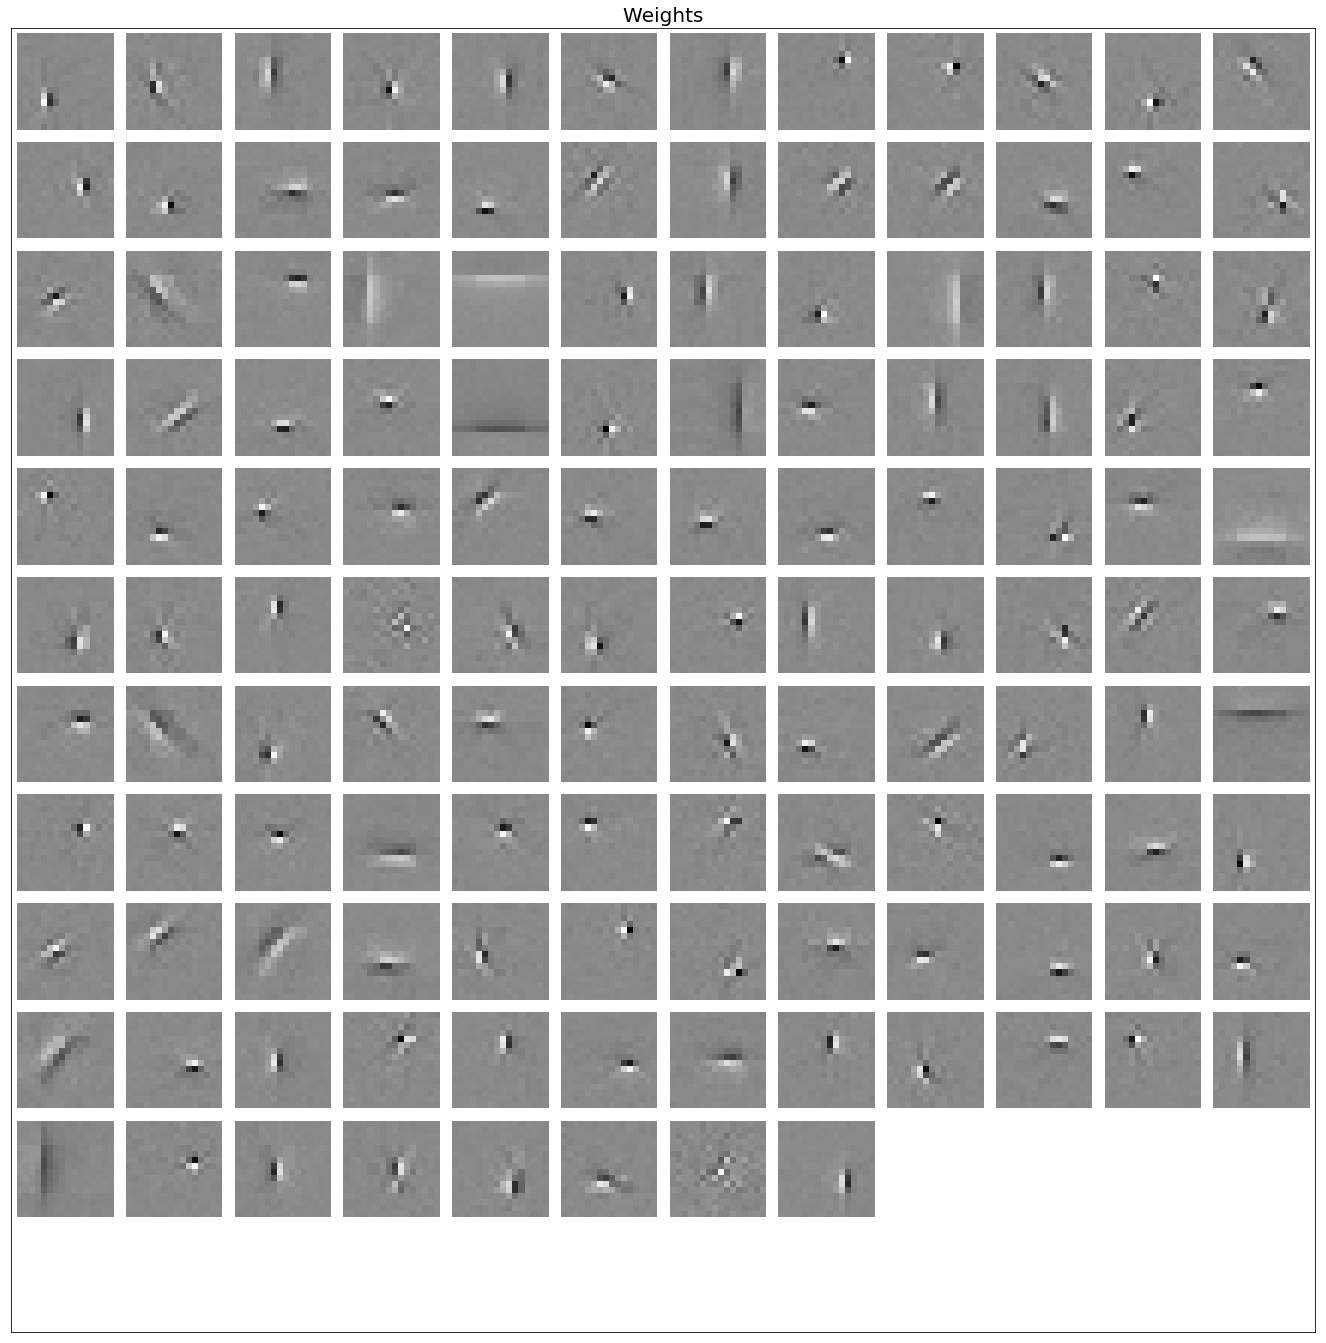

In [5]:
num_pixels = analyzer.model_params["patch_size_x"]*analyzer.model_params["patch_size_y"]
weights = analyzer.evals["weights/phi:0"].reshape((num_pixels, analyzer.model_params["num_neurons"]))
dict_fig = pf.plot_data_tiled(weights.T, normalize=False, title="Weights")

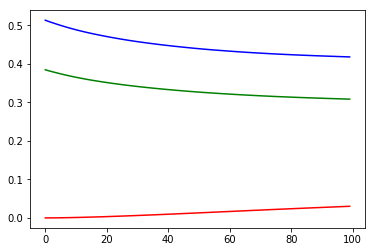

In [6]:
fig, ax = plt.subplots(1)
ax.plot(analyzer.adversarial_target_adv_mses, 'b')
ax.plot(analyzer.adversarial_input_adv_mses, 'r')
ax.plot(analyzer.adversarial_target_recon_mses, 'g')
plt.show()

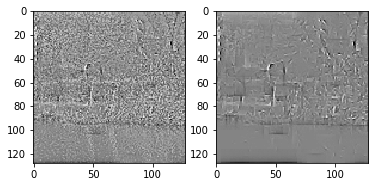

In [7]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.squeeze(analyzer.adversarial_images[-1]), cmap="Greys_r")
ax[1].imshow(np.squeeze(analyzer.adversarial_recons[-1]), cmap="Greys_r")
plt.show()

In [8]:
input_image = imread(analyzer.analysis_out_dir+"/vis/inputs/downtown_sf.png", flatten=True)[:,:,None]
input_image = dp.downsample_data(input_image, scale_factor=[0.5, 0.5, 1], order=3)
input_image /= 255.0
wht_input_image, input_mean, input_filter = dp.whiten_data(input_image, method="FT")
unwht_input = dp.unwhiten_data(wht_input_image, input_mean, input_filter, method="FT")

In [9]:
target_image = imread(analyzer.analysis_out_dir+"/vis/inputs/trees.png", flatten=True)[:,:,None]
target_image = dp.downsample_data(target_image, scale_factor=[0.5, 0.5, 1], order=3)
target_image /= 255.0
wht_target_image, target_mean, target_filter = dp.whiten_data(target_image, method="FT")
unwht_target = dp.unwhiten_data(wht_target_image, target_mean, target_filter, method="FT")

In [10]:
analyzer.do_adversaries = True
analyzer.setup_model(analyzer.model_params, analyzer.model_schedule)

In [11]:
adv_images, recons, mses = analyzer.construct_adversarial_stimulus(wht_input_image[None,...], wht_target_image[None,...],
  eps=0.001, num_steps=10000)

INFO:tensorflow:Restoring parameters from /home/dpaiton/Work/Projects/conv_lca/checkpoints/conv_lca_v0.0_weights-100000


In [12]:
np.min(np.abs(adv_images[-1]-adv_images[1]))

0.00015843923517877556

In [22]:
unwht_recons = [np.squeeze(dp.unwhiten_data(recon, input_mean, input_filter, method="FT")) for recon in adv_images]

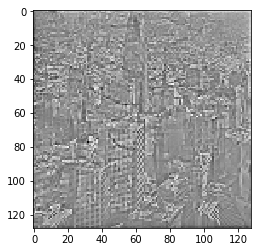

In [21]:
plt.imshow(np.squeeze(adv_images[1000]), cmap="Greys_r")
plt.show()

In [23]:
#cln_recons = [np.squeeze((recon-np.min(recon))/(np.max(recon)-np.min(recon))) for recon in recons]
cln_recons = [np.squeeze((recon-np.min(recon))/(np.max(recon)-np.min(recon))) for recon in unwht_recons]

In [24]:
lin_interp = [np.squeeze((1-a)*input_image+a*target_image) for a in np.linspace(0, 1, 10000)]

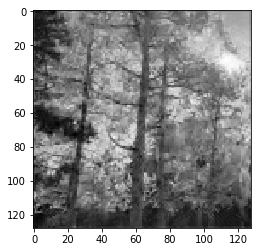

In [26]:
from matplotlib import animation
from IPython.display import HTML

def make_movie(frames):
  fig, ax = plt.subplots()
  
  im = ax.imshow(np.zeros_like(frames[0]), cmap="Greys_r", vmin=0.0, vmax=1.0)
  
  def init():
      im.set_data(np.zeros_like(frames[0]))
      return (im,)
    
  def animate(i):
    im.set_data(frames[i])
    return (im,)
  
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=len(frames), interval=20, 
                                 blit=True)
  return anim

anim = make_movie(cln_recons)
HTML(anim.to_html5_video())

In [17]:
def plot_weight_bars(weights, bf_idx=0):
  bf_stats = dp.get_dictionary_stats(weights, padding=32)
  center = bf_stats["gauss_centers"][bf_idx]
  orientations = bf_stats["fourier_centers"][bf_idx]
  angle = np.rad2deg(np.pi/2 + np.arctan2(*orientations)) 
  patch_edge_size = bf_stats["patch_edge_size"]
  vals = np.linspace(0,patch_edge_size,patch_edge_size)
  X,Y = np.meshgrid(vals,vals)
  output = np.zeros((patch_edge_size, patch_edge_size))
  return output

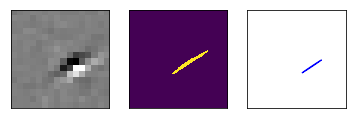

In [241]:
bf_idx = 35
bf = bf_stats["basis_functions"][bf_idx]
center = bf_stats["gauss_centers"][bf_idx]
evals, evecs = bf_stats["gauss_orientations"][bf_idx]
width, height = evals
min_length = 0.3
if width < height:
  width = min_length
elif width > height:
  height = min_length
orientations = bf_stats["fourier_centers"][bf_idx]
patch_edge_size = bf_stats["patch_edge_size"]

y0,x0 = center
x = np.linspace(0, patch_edge_size, 100)  # x values of interest
y = np.linspace(0, patch_edge_size, 100)[:,None]  # y values of interest, as a "column" array
angle = np.pi/2+np.arctan2(*orientations)
ellipse = ((np.cos(angle)*(x-x0) + np.sin(angle)*(y-y0))**2/width**2
  + (np.sin(angle)*(x-x0) - np.cos(angle)*(y-y0))**2/height**2) <= 1

fig, ax = plt.subplots(1,3)
ax[0] = pf.clear_axis(ax[0], spines="k")
ax[0].imshow(bf, cmap="Greys_r", interpolation="Nearest")
ax[1] = pf.clear_axis(ax[1], spines="k")
ax[1].imshow(ellipse)
ax[2] = pf.clear_axis(ax[2], spines="k")
el = pf.plot_ellipse(ax[2], center, evals, np.rad2deg(angle), color_val="b", alpha=1.0, lines=True)
ax[2].set_xlim(0, patch_edge_size-1)
ax[2].set_ylim(patch_edge_size-1, 0)
ax[2].set_aspect("equal")
plt.show()

In [18]:
bf_stats = plot_weight_bars(weights)

AssertionError: weights.shape[0] must have an even square root.

In [ ]:
#data = ds.get_data(analyzer.model_params)
#data = analyzer.model.preprocess_dataset(data, analyzer.model_params)
#data = analyzer.model.reshape_dataset(data, analyzer.model_params)
#
#import matplotlib.pyplot as plt
#plt.imshow(data["train"].images[0,...])
#plt.show()

In [ ]:
#print("Analysis params:\n")
#print("\n".join([key.ljust(20)+"\t"+str(analyzer.model_params[key]) for key in analyzer.model_params]))

##### Notes
a_vals during inference are extremely high for conv lca on cifar
this is causing inf in loss values
need to train new conv lca on VH whitened
figure out a_vals for those
what in conv LCA would be causing the values to be so high??

In [ ]:
stats_fig = pf.plot_stats(analyzer.run_stats,
  keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"],
  labels=["activity", "recon loss", "sparse loss", "total loss"])

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits import axes_grid1
import utils.data_processing as dp

def plot_inference_stats(data, title="", save_filename=None):
  """
  Plot loss values during LCA inference
  Inputs:
    data: [dict] that must contain the "losses"
      this can be created by using the LCA analyzer objects
  """
  labels = [key for key in data["losses"].keys()]
  losses = [val for val in data["losses"].values()]
  num_im, num_steps = losses[0].shape
  means = [None,]*len(labels)
  sems = [None,]*len(labels)
  for loss_id, loss in enumerate(losses):
    means[loss_id] = np.mean(loss, axis=0) # mean across num_imgs
    sems[loss_id] = np.std(loss, axis=0) / np.sqrt(num_im)
  num_plots_y = np.int32(np.ceil(np.sqrt(len(labels))))+1
  num_plots_x = np.int32(np.ceil(np.sqrt(len(labels))))
  gs = gridspec.GridSpec(num_plots_y, num_plots_x)
  fig = plt.figure(figsize=(10,10))
  loss_id = 0
  for plot_id in np.ndindex((num_plots_y, num_plots_x)):
    (y_id, x_id) = plot_id
    ax = fig.add_subplot(gs[plot_id])
    if loss_id < len(labels):
      time_steps = np.arange(num_steps)
      ax.plot(time_steps, means[loss_id], "k-")
      ax.fill_between(time_steps, means[loss_id]-sems[loss_id],
        means[loss_id]+sems[loss_id], alpha=0.2)
      ax.set_ylabel(labels[loss_id].replace('_', ' '), fontsize=16)
      ax.set_xlim([1, np.max(time_steps)])
      ax.set_xticks([1, int(np.floor(np.max(time_steps)/2)), np.max(time_steps)])
      ax.set_xlabel("Time Step", fontsize=16)
      ax.tick_params("both", labelsize=14)
      loss_id += 1
    else:
      ax = pf.clear_axis(ax, spines="none")
  fig.tight_layout()
  fig.suptitle(title, y=1.03, x=0.5, fontsize=20)
  if save_filename is not None:
    fig.savefig(save_filename, transparent=True)
    plt.close(fig)
    return None
  plt.show()
  return fig

In [ ]:
fig = pf.plot_inference_stats(analyzer.inference_stats, title="Loss During Inference")

In [ ]:
num_pixels, num_neurons = analyzer.atas.shape
atas_fig = pf.plot_data_tiled(analyzer.atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))), normalize=False,
  title="Activity triggered averages on image data")

In [ ]:
noise_images = np.random.standard_normal(data["train"].images.shape) 
noise_evals = analyzer.evaluate_model(noise_images, analyzer.var_names)
noise_atas = analyzer.compute_atas(noise_evals["inference/activity:0"],
  noise_images)
noise_atas_fig = pf.plot_data_tiled(noise_atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))), normalize=False,
  title="Activity triggered averages on standard normal noise data")

In [ ]:
inference_fig = pf.plot_inference_traces(analyzer.inference_stats, analyzer.model_schedule[0]["sparse_mult"])

In [ ]:
fig = pf.plot_inference_stats(analyzer.inference_stats, title="Loss During Inference")